In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [21]:
results_folder = "results_05_15"
template_image_path = './images/image_to_search.jpg'
img1_path = './images/25_sept_2021.JPG'
img2_path = './images/18_apr_2022.JPG'


def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    #rect = pts
    (tl, tr, br, bl) = rect
    #(tl, bl, br, tr) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

In [150]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
MIN_MATCH_COUNT = 10

from imutils import paths
import numpy as np
import argparse
import imutils
import cv2
import os


img2 = cv.imread(img1_path)          # queryImage
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img1 = cv.imread(template_image_path) # trainImage
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)



In [151]:
print(np.shape(good))

(268,)


In [152]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = np.shape(img1[:,:,0])
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    #img2_lines = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

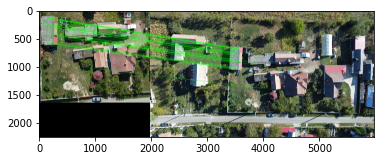

True

In [153]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.imshow(img3, 'gray'),plt.show()
# Save the output.
img3 = cv2.cvtColor(img3, cv2.COLOR_RGB2BGR)
cv.imwrite(results_folder + '/to_crop.jpg', img3)


In [154]:
print(dst)
print(dst[2][0][0])


[[[1398.2495   571.38477]]

 [[1344.6619  1859.7345 ]]

 [[3019.9827  1975.2467 ]]

 [[3073.4832   544.5165 ]]]
3019.9827


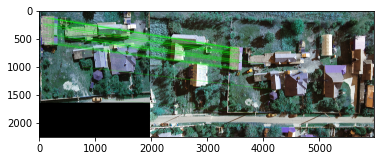

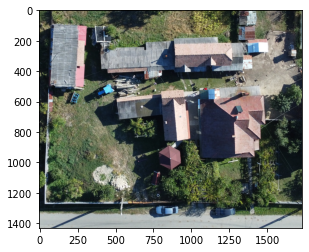

True

In [155]:
top_left_x = int(min([dst[0][0][0],dst[1][0][0],dst[2][0][0],dst[3][0][0]]))
top_left_y = int(min([dst[0][0][1],dst[1][0][1],dst[2][0][1],dst[3][0][1]]))
bot_right_x = int(max([dst[0][0][0],dst[1][0][0],dst[2][0][0],dst[3][0][0]]))
bot_right_y = int(max([dst[0][0][1],dst[1][0][1],dst[2][0][1],dst[3][0][1]]))

img_4 = img2[top_left_y:bot_right_y, top_left_x:bot_right_x]


plt.imshow(img3, 'gray'),plt.show()
plt.imshow(img_4, 'gray'),plt.show()
# Save the output.

img_4 = cv2.cvtColor(img_4, cv2.COLOR_RGB2BGR)
cv.imwrite(results_folder + '/cropped_img.jpg', img_4)


In [156]:
dst = dst.reshape(4,2)


print(np.shape(dst))
warped = four_point_transform(img2, dst)

(4, 2)


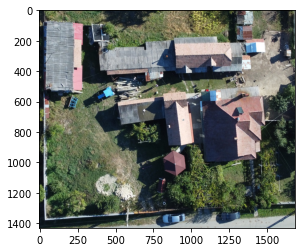

True

In [157]:
plt.imshow(warped, 'gray'),plt.show()
# Save the output.
resized_img_2 = cv2.resize(img1, (1200, 1200)) 
resized_img_2 = cv2.cvtColor(resized_img_2, cv2.COLOR_RGB2BGR)
cv.imwrite(results_folder + '/resized_img_2.jpg', resized_img_2)


resized_warped = cv2.resize(warped, (1200, 1200)) 
resized_warped = cv2.cvtColor(resized_warped, cv2.COLOR_RGB2BGR)
cv.imwrite(results_folder + '/resized_warped.jpg', resized_warped)
